# Understanding ambiguity in the lexicon

Here, we explore and attempt to understand the finding that short words tend to have more homophones, at least in English, German, and Dutch. This has been suggested (Piantadosi et al, 2012) as evidence that language evolution selects for **efficiency** by recycling short, presumably easier-to-produce homophones. The original result contains three findings:
* Short words have more homophones
* More frequent words have more homophones
* More phonotactically-probable words have more homophones

But one might ask: is this data best explained by a psychological pressure to **reuse** short words, or can it be equally-well explained by the observation that, independent of psychological pressures, short words should acquire more homophones because:
1. There is simply a higher density of short words in the lexicon, e.g. the ratio of **actual** words to **potential** words is higher for short words than long words.
2. Given the addition of a new word-form (e.g. by sound change, neologisms, etc.), *short* word-forms are more likely to create homophones than long word-forms because there is a greater chance of overlap. (Or conversely, a lower chance of *non-overlap*.)

This makes two predictions:

First, we should observe the same or greater relationship between **word length** and **number of homophones** in randomly-generated lexicons that *look like* English but haven't been subjected to the same psychological pressures. We should also observe the same or greater relationship between **phonotactic probability** and **number of homophones**. Given that we can't obtain frequency estimates for nonexistent words, we cannot test the relationship between **frequency** and **number of homophones**.

Second, we should find that simulating mechanisms of language change, e.g. **sound change**, is more likely to produce homophones for short words than long words.

Note that this explanation is not incompatible with the account offered by Piantadosi et al (2012). Rather, it attempts to clarify why ambiguity in the lexicon is distributed in such a way. There could still be a psychological pressure for short words––but not necessariliy a pressure to **reuse** short words.

# Part 1: Replicate the original finding

First, we attempt to replicate the original finding, using both CELEX and iPHOD. We use the latter because this will be our point of comparison for pseudo-words.

## CELEX replication

Using data from CELEX, we identify the number of homophones for each wordform, then regress **number of homophones** against **number of syllables**. 


In [49]:
import pandas as pd 
import scipy.stats as ss
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import src.utils as utils
import math
import seaborn as sns
from tqdm import tqdm
from os import listdir


In [18]:
# ~ 52k words, slightly different from Piantadosi
df = pd.read_csv("data/raw/celex_all.csv", sep="\\")


In [19]:
# Preprocess
df_processed = utils.preprocess_for_analysis(df)

# Analysis
result = sm.poisson(formula="num_homophones ~ SylCnt", data=df_processed).fit()
result.summary()

/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


Optimization terminated successfully.
         Current function value: 0.469239
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:         num_homophones   No. Observations:                35111
Model:                        Poisson   Df Residuals:                    35109
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:                  0.1345
Time:                        15:55:09   Log-Likelihood:                -16475.
converged:                       True   LL-Null:                       -19035.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5035      0.030     16.514      0.000       0.444       0.563
SylCnt        -0.9464      0.015    -63.308      0.000      -0.976      -0.917
==============================================================================
"""

In [23]:
# sns.lmplot(x='SylCnt',y='num_homophones',data=df_processed,fit_reg=True) 

Above, we successfully replicate the finding reported in Piantadosi et al (2012). For reference, they report that all coefficients on *SylCnt* < -.85. We find a similar value, though slightly larger magnitude (probably because we also omit frequency and phonotactic probability, which might explain overlapping variance).

In [26]:
print("Coef = {}".format(result.params['SylCnt']))

Coef = -0.9463926929646335


## IPHOD replication

Using data from [IPHOD](http://iphod.com/), we identify the number of homophones for each wordform, then regress **number of homophones** against **number of syllables** and **phonotactic surprisal**. 

The motivation for using IPHOD here is that IPHOD also has a list of phonotactically-possible English pseudo-words, which we will use to simulate our random lexicons. 

Below, we *save* the values for the coefficients for both both *surprisal* and *number of syllables*. We will then ask whether these coefficients are larger than what you'd expect in a random lexicon.

In [39]:
# Parameters
params = {'syllable_term': 'NSyll',
		  'phoneme_term': 'NPhon'}

FORMULA = 'num_homophones ~ {syl} + {prob}'.format(syl=params['syllable_term'],
												   prob='surprisal')
PHON_COLUMN = 'StTrn'

# Read in data
df = pd.read_csv("data/raw/IPhODv2.0_REALS/IPhOD2_Words.txt", sep="\t")

# Preprocess
df_processed = utils.preprocess_for_analysis(df, phon_column=PHON_COLUMN)
print("{X} words in final analysis".format(X=len(df_processed)))

/Users/seantrott/Dropbox/UCSD/Research/Ambiguity/Evolution/homophone_simulations/src/utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['remove'] = df[word_column].apply(remove_word)


51956 words in final analysis


In [40]:
df_processed['surprisal'] = df_processed['strTPAV'] / df_processed['NPhon']
result = sm.poisson(formula=FORMULA, data=df_processed).fit()
result.summary()

         Current function value: 0.367186
         Iterations: 35


/Users/seantrott/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:         num_homophones   No. Observations:                51956
Model:                        Poisson   Df Residuals:                    51953
Method:                           MLE   Df Model:                            2
Date:                Thu, 07 Mar 2019   Pseudo R-squ.:                  -1.107
Time:                        16:05:47   Log-Likelihood:                -19078.
converged:                      False   LL-Null:                       -9055.4
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9525      0.057     16.630      0.000       0.840       1.065
NSyll         -1.0394      0.036    -28.633      0.000      -1.111      -0.968
surprisal  -2.708e+05   6918.644    -39.135      0.000   -2.84e+05   -2.57e+05
==============================================================================
"""

In [41]:
REAL_LENGTH_COEF = result.params['NSyll']
REAL_SURPRISAL_COEF = result.params['surprisal']
REAL_INTERCEPT = result.params['Intercept']
NUM_WORDS = len(df_processed)

# Part 2: Conduct same analysis on pseudo-words

Now we conduct the same analyses on the set of pseudowords in IPHOD. Specifically, we randomly sample from the 814840 pseudowords 100 times. Each time, we construct a random lexicon of roughly the same size (~50k words), with the same distribution of word lengths and word probabilities.

## Loading and processing data

In [52]:
PATH = "data/raw/IPhODv2.0_PSEUDO"
PHON_COLUMN = 'StTrn'

In [50]:
sources = []
files = listdir(PATH)
print("Loading pseudo-words from files...")
for f in tqdm(files):
	if "IPhOD2_Pseudos" in f:
		temp = pd.read_csv("{path}/{file_name}".format(path=PATH, file_name=f), sep="\t")
		sources.append(temp)

df = pd.concat(sources)

  0%|          | 0/19 [00:00<?, ?it/s]

Loading pseudo-words from files...


100%|██████████| 19/19 [00:14<00:00,  1.81s/it]


In [51]:
print("{X} pseudowords in all.".format(X=len(df)))

814840 pseudowords in all.


In [53]:
df = df.drop_duplicates(subset=PHON_COLUMN)
print("{X} pseudowords after dropping duplicate wordforms.".format(X=len(df)))

761688 pseudowords after dropping duplicate wordforms.


## Running simulations

In [58]:
ACTUAL_DISTRIBUTION = {2: 21402, 3: 14433, 1: 8428, 4: 6804, 5: 2408, 6: 485, 7: 56, 8: 8, 12: 1, 9: 1}
ITERATIONS = 100

In [59]:
length_coefs, phonotactic_coefs = [], []
df['surprisal'] = df['strTPAV'] / df['NPhon']

In [60]:
for i in tqdm(list(range(ITERATIONS))):

    # Sample an appropriate amount of words from each length
    temp = []
    for syl, num in ACTUAL_DISTRIBUTION.items():
        df_subset = df[df['NSyll']==syl]
        if len(df_subset) > 0: # num
            temp.append(df_subset.sample(num, 
                                         replace=True,
                                         weights=df_subset['surprisal']))


    df_sampled = pd.concat(temp)

    # df_sampled = df.sample(N, replace=True)
    df_sampled['Word_recoded'] = df_sampled['Word'].apply(lambda x: x.split(" (")[0])

    # Preprocess
    df_processed = utils.preprocess_for_analysis(df_sampled, 
                                                 word_column='Word_recoded',
                                                 phon_column=PHON_COLUMN)

    # Analysis
    result = sm.poisson(formula=FORMULA, data=df_processed).fit()

    length_coefs.append(result.params['NSyll'])
    phonotactic_coefs.append(result.params['surprisal'])

  1%|          | 1/100 [00:02<04:11,  2.54s/it]

Optimization terminated successfully.
         Current function value: 0.344757
         Iterations 28


  2%|▏         | 2/100 [00:04<03:56,  2.41s/it]

Optimization terminated successfully.
         Current function value: 0.337664
         Iterations 28


  3%|▎         | 3/100 [00:06<03:44,  2.32s/it]

Optimization terminated successfully.
         Current function value: 0.340294
         Iterations 29


  4%|▍         | 4/100 [00:08<03:33,  2.22s/it]

Optimization terminated successfully.
         Current function value: 0.339376
         Iterations 28


  5%|▌         | 5/100 [00:10<03:25,  2.16s/it]

Optimization terminated successfully.
         Current function value: 0.340677
         Iterations 29


  6%|▌         | 6/100 [00:12<03:20,  2.13s/it]

Optimization terminated successfully.
         Current function value: 0.333200
         Iterations 29


  7%|▋         | 7/100 [00:14<03:16,  2.12s/it]

Optimization terminated successfully.
         Current function value: 0.335501
         Iterations 28


  8%|▊         | 8/100 [00:17<03:23,  2.21s/it]

Optimization terminated successfully.
         Current function value: 0.336924
         Iterations 30


  9%|▉         | 9/100 [00:19<03:15,  2.15s/it]

Optimization terminated successfully.
         Current function value: 0.336574
         Iterations 28


 10%|█         | 10/100 [00:21<03:07,  2.08s/it]

Optimization terminated successfully.
         Current function value: 0.335879
         Iterations 29


 11%|█         | 11/100 [00:23<03:01,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.341118
         Iterations 28


 12%|█▏        | 12/100 [00:25<02:57,  2.02s/it]

Optimization terminated successfully.
         Current function value: 0.339798
         Iterations 28


 13%|█▎        | 13/100 [00:27<02:53,  1.99s/it]

Optimization terminated successfully.
         Current function value: 0.335605
         Iterations 29


 14%|█▍        | 14/100 [00:29<02:50,  1.98s/it]

Optimization terminated successfully.
         Current function value: 0.331341
         Iterations 29


 15%|█▌        | 15/100 [00:30<02:46,  1.96s/it]

Optimization terminated successfully.
         Current function value: 0.334683
         Iterations 29


 16%|█▌        | 16/100 [00:32<02:43,  1.95s/it]

Optimization terminated successfully.
         Current function value: 0.338851
         Iterations 27


 17%|█▋        | 17/100 [00:34<02:41,  1.95s/it]

Optimization terminated successfully.
         Current function value: 0.336562
         Iterations 29


 18%|█▊        | 18/100 [00:36<02:39,  1.94s/it]

Optimization terminated successfully.
         Current function value: 0.337762
         Iterations 29


 19%|█▉        | 19/100 [00:38<02:36,  1.94s/it]

Optimization terminated successfully.
         Current function value: 0.338115
         Iterations 28


 20%|██        | 20/100 [00:40<02:34,  1.94s/it]

Optimization terminated successfully.
         Current function value: 0.334060
         Iterations 29


 21%|██        | 21/100 [00:42<02:32,  1.93s/it]

Optimization terminated successfully.
         Current function value: 0.338522
         Iterations 29


 22%|██▏       | 22/100 [00:44<02:38,  2.03s/it]

Optimization terminated successfully.
         Current function value: 0.329926
         Iterations 30


 23%|██▎       | 23/100 [00:46<02:37,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.344928
         Iterations 28


 24%|██▍       | 24/100 [00:48<02:35,  2.05s/it]

Optimization terminated successfully.
         Current function value: 0.335738
         Iterations 30


 25%|██▌       | 25/100 [00:50<02:32,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.336810
         Iterations 28


 26%|██▌       | 26/100 [00:53<02:31,  2.05s/it]

Optimization terminated successfully.
         Current function value: 0.340736
         Iterations 27


 27%|██▋       | 27/100 [00:55<02:29,  2.05s/it]

Optimization terminated successfully.
         Current function value: 0.338829
         Iterations 29


 28%|██▊       | 28/100 [00:57<02:27,  2.05s/it]

Optimization terminated successfully.
         Current function value: 0.338973
         Iterations 29


 29%|██▉       | 29/100 [00:59<02:25,  2.05s/it]

Optimization terminated successfully.
         Current function value: 0.336823
         Iterations 29


 30%|███       | 30/100 [01:01<02:22,  2.03s/it]

Optimization terminated successfully.
         Current function value: 0.331526
         Iterations 28


 31%|███       | 31/100 [01:03<02:20,  2.03s/it]

Optimization terminated successfully.
         Current function value: 0.339737
         Iterations 28


 32%|███▏      | 32/100 [01:05<02:18,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.339776
         Iterations 28


 33%|███▎      | 33/100 [01:07<02:16,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.339759
         Iterations 28


 34%|███▍      | 34/100 [01:09<02:14,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.335665
         Iterations 29


 35%|███▌      | 35/100 [01:11<02:12,  2.03s/it]

Optimization terminated successfully.
         Current function value: 0.340136
         Iterations 28


 36%|███▌      | 36/100 [01:13<02:10,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.341265
         Iterations 28


 37%|███▋      | 37/100 [01:15<02:08,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.340798
         Iterations 27


 38%|███▊      | 38/100 [01:17<02:06,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.336713
         Iterations 29


 39%|███▉      | 39/100 [01:19<02:03,  2.03s/it]

Optimization terminated successfully.
         Current function value: 0.339433
         Iterations 27


 40%|████      | 40/100 [01:21<02:01,  2.03s/it]

Optimization terminated successfully.
         Current function value: 0.335480
         Iterations 28


 41%|████      | 41/100 [01:23<01:59,  2.02s/it]

Optimization terminated successfully.
         Current function value: 0.340319
         Iterations 26


 42%|████▏     | 42/100 [01:25<01:56,  2.02s/it]

Optimization terminated successfully.
         Current function value: 0.344593
         Iterations 27


 43%|████▎     | 43/100 [01:27<01:55,  2.03s/it]

Optimization terminated successfully.
         Current function value: 0.341041
         Iterations 29


 44%|████▍     | 44/100 [01:29<01:54,  2.05s/it]

Optimization terminated successfully.
         Current function value: 0.340085
         Iterations 29


 45%|████▌     | 45/100 [01:31<01:52,  2.05s/it]

Optimization terminated successfully.
         Current function value: 0.336862
         Iterations 29


 46%|████▌     | 46/100 [01:33<01:51,  2.07s/it]

Optimization terminated successfully.
         Current function value: 0.336668
         Iterations 28


 47%|████▋     | 47/100 [01:35<01:49,  2.06s/it]

Optimization terminated successfully.
         Current function value: 0.343128
         Iterations 28


 48%|████▊     | 48/100 [01:37<01:47,  2.06s/it]

Optimization terminated successfully.
         Current function value: 0.327997
         Iterations 30


 49%|████▉     | 49/100 [01:39<01:44,  2.06s/it]

Optimization terminated successfully.
         Current function value: 0.339634
         Iterations 28


 50%|█████     | 50/100 [01:42<01:42,  2.05s/it]

Optimization terminated successfully.
         Current function value: 0.339543
         Iterations 28


 51%|█████     | 51/100 [01:44<01:40,  2.06s/it]

Optimization terminated successfully.
         Current function value: 0.343101
         Iterations 29


 52%|█████▏    | 52/100 [01:46<01:37,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.342181
         Iterations 26


 53%|█████▎    | 53/100 [01:48<01:35,  2.03s/it]

Optimization terminated successfully.
         Current function value: 0.336849
         Iterations 28


 54%|█████▍    | 54/100 [01:50<01:32,  2.02s/it]

Optimization terminated successfully.
         Current function value: 0.343553
         Iterations 27


 55%|█████▌    | 55/100 [01:52<01:32,  2.06s/it]

Optimization terminated successfully.
         Current function value: 0.334151
         Iterations 28


 56%|█████▌    | 56/100 [01:54<01:32,  2.10s/it]

Optimization terminated successfully.
         Current function value: 0.335411
         Iterations 29


 57%|█████▋    | 57/100 [01:56<01:29,  2.09s/it]

Optimization terminated successfully.
         Current function value: 0.337764
         Iterations 28


 58%|█████▊    | 58/100 [01:58<01:26,  2.07s/it]

Optimization terminated successfully.
         Current function value: 0.338823
         Iterations 28


 59%|█████▉    | 59/100 [02:00<01:24,  2.06s/it]

Optimization terminated successfully.
         Current function value: 0.334967
         Iterations 29


 60%|██████    | 60/100 [02:02<01:21,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.338643
         Iterations 28


 61%|██████    | 61/100 [02:04<01:20,  2.06s/it]

Optimization terminated successfully.
         Current function value: 0.337017
         Iterations 29


 62%|██████▏   | 62/100 [02:06<01:18,  2.06s/it]

Optimization terminated successfully.
         Current function value: 0.336847
         Iterations 29


 63%|██████▎   | 63/100 [02:08<01:15,  2.05s/it]

Optimization terminated successfully.
         Current function value: 0.341761
         Iterations 28


 64%|██████▍   | 64/100 [02:10<01:13,  2.05s/it]

Optimization terminated successfully.
         Current function value: 0.335781
         Iterations 30


 65%|██████▌   | 65/100 [02:12<01:11,  2.05s/it]

Optimization terminated successfully.
         Current function value: 0.341218
         Iterations 29


 66%|██████▌   | 66/100 [02:14<01:09,  2.05s/it]

Optimization terminated successfully.
         Current function value: 0.336293
         Iterations 28


 67%|██████▋   | 67/100 [02:16<01:07,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.342582
         Iterations 27


 68%|██████▊   | 68/100 [02:18<01:05,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.338152
         Iterations 29


 69%|██████▉   | 69/100 [02:20<01:02,  2.02s/it]

Optimization terminated successfully.
         Current function value: 0.341377
         Iterations 28


 70%|███████   | 70/100 [02:22<01:00,  2.02s/it]

Optimization terminated successfully.
         Current function value: 0.337233
         Iterations 30


 71%|███████   | 71/100 [02:24<00:58,  2.01s/it]

Optimization terminated successfully.
         Current function value: 0.345256
         Iterations 28


 72%|███████▏  | 72/100 [02:27<00:56,  2.03s/it]

Optimization terminated successfully.
         Current function value: 0.335181
         Iterations 29


 73%|███████▎  | 73/100 [02:29<00:54,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.340857
         Iterations 29


 74%|███████▍  | 74/100 [02:31<00:53,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.338644
         Iterations 28


 75%|███████▌  | 75/100 [02:33<00:51,  2.05s/it]

Optimization terminated successfully.
         Current function value: 0.341766
         Iterations 27


 76%|███████▌  | 76/100 [02:35<00:49,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.338815
         Iterations 28


 77%|███████▋  | 77/100 [02:37<00:47,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.335625
         Iterations 26


 78%|███████▊  | 78/100 [02:39<00:44,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.337353
         Iterations 29


 79%|███████▉  | 79/100 [02:41<00:42,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.338858
         Iterations 27


 80%|████████  | 80/100 [02:43<00:40,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.342534
         Iterations 28


 81%|████████  | 81/100 [02:45<00:38,  2.05s/it]

Optimization terminated successfully.
         Current function value: 0.345609
         Iterations 28


 82%|████████▏ | 82/100 [02:47<00:36,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.330182
         Iterations 28


 83%|████████▎ | 83/100 [02:49<00:34,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.336170
         Iterations 29


 84%|████████▍ | 84/100 [02:51<00:32,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.341559
         Iterations 28


 85%|████████▌ | 85/100 [02:53<00:30,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.339592
         Iterations 28


 86%|████████▌ | 86/100 [02:55<00:28,  2.05s/it]

Optimization terminated successfully.
         Current function value: 0.336777
         Iterations 28


 87%|████████▋ | 87/100 [02:57<00:26,  2.03s/it]

Optimization terminated successfully.
         Current function value: 0.340338
         Iterations 28


 88%|████████▊ | 88/100 [02:59<00:24,  2.03s/it]

Optimization terminated successfully.
         Current function value: 0.336619
         Iterations 28


 89%|████████▉ | 89/100 [03:01<00:22,  2.02s/it]

Optimization terminated successfully.
         Current function value: 0.340797
         Iterations 28


 90%|█████████ | 90/100 [03:03<00:20,  2.02s/it]

Optimization terminated successfully.
         Current function value: 0.345092
         Iterations 27


 91%|█████████ | 91/100 [03:05<00:18,  2.03s/it]

Optimization terminated successfully.
         Current function value: 0.333021
         Iterations 28


 92%|█████████▏| 92/100 [03:07<00:16,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.341424
         Iterations 29


 93%|█████████▎| 93/100 [03:09<00:14,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.343392
         Iterations 28


 94%|█████████▍| 94/100 [03:11<00:12,  2.03s/it]

Optimization terminated successfully.
         Current function value: 0.341158
         Iterations 26


 95%|█████████▌| 95/100 [03:13<00:10,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.333517
         Iterations 28


 96%|█████████▌| 96/100 [03:15<00:08,  2.03s/it]

Optimization terminated successfully.
         Current function value: 0.339077
         Iterations 29


 97%|█████████▋| 97/100 [03:17<00:06,  2.03s/it]

Optimization terminated successfully.
         Current function value: 0.336562
         Iterations 29


 98%|█████████▊| 98/100 [03:19<00:04,  2.03s/it]

Optimization terminated successfully.
         Current function value: 0.341017
         Iterations 29


 99%|█████████▉| 99/100 [03:22<00:02,  2.03s/it]

Optimization terminated successfully.
         Current function value: 0.334693
         Iterations 29


100%|██████████| 100/100 [03:24<00:00,  2.04s/it]

Optimization terminated successfully.
         Current function value: 0.337578
         Iterations 28


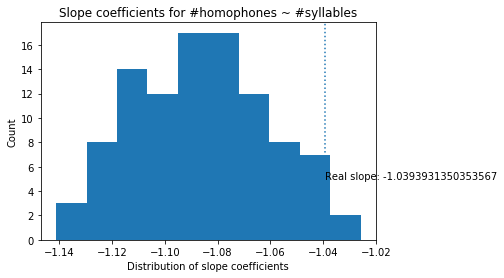

In [76]:
plt.hist(length_coefs)
plt.axvline(x=REAL_LENGTH_COEF, linestyle="dotted")
# plt.axvline(x=mean_random_slope, linestyle="dotted", color="blue")
plt.text(s="Real slope: {sl}".format(sl=REAL_LENGTH_COEF),x=REAL_LENGTH_COEF, y=5)
# plt.xlim(-.05, .05)
plt.xlabel("Distribution of slope coefficients")
plt.ylabel("Count")
plt.title("Slope coefficients for #homophones ~ #syllables")
plt.show()
